### Simulating Brownina motion

In [82]:
import torch 
from abc import ABC, abstractmethod 
import matplotlib.pyplot as plt 
from typing import Optional
from matplotlib.axes._axes import Axes

In [192]:
class SDE(ABC):
    @abstractmethod 
    def drift_comp(self, x0, t):
        pass 

    @abstractmethod
    def diff_comp(self, x0, t):
        pass 

class Simulator(ABC):
    @abstractmethod 
    def step(self, x, t, h):
        pass 

    @torch.no_grad()
    def simulate(self, x0, ts):
        for idx in range(1, len(ts)):
            t = ts[idx - 1] 
            h = ts[idx] - ts[idx - 1]
            x0 = self.step(x0, t, h)
        return x0

    @torch.no_grad()
    def simulate_with_trajectory(self, x0, ts):
        trajectory = [x0.clone()]
        for idx in range(1, len(ts)):
            t = ts[idx - 1] 
            h = ts[idx] - ts[idx - 1] 
            x0 = self.step(x0, t, h)
            trajectory.append(x0.clone())
        res = torch.stack(trajectory, dim=1)    # [bs, ts, 1]
        return res   


$X_{t+h} = X_t + hu_t(X_t) + \sigma \sqrt{h} \epsilon$

In [202]:
class EM(Simulator):
    def __init__(self, sde):
        self.sde = sde 
    
    def step(self, x, t, h):
        res = x + self.sde.drift_comp(x, t) * h + self.sde.diff_comp(x, t) * torch.sqrt(h) * torch.randn_like(x)
        return res

In [203]:
class Weiner(SDE):
    def __init__(self, sigma):
        self.sigma = sigma
    
    def drift_comp(self, x, t):
        return torch.zeros_like(x) 
    
    def diff_comp(self, x, t):
        return self.sigma * torch.ones_like(x)

In [133]:
class OU(SDE):
    def __init__(self, theta, sigma):
        self.theta = theta 
        self.sigma = sigma 
    
    def drift_comp(self, xt, t):
        return - self.theta * xt

    def diff_comp(self, xt, t):
        return self.sigma * torch.ones_like(xt)


In [168]:
class Cox(SDE):
    def __init__(self, mu, theta, sigma):
        self.theta = theta 
        self.sigma = sigma 
        self.mu = mu
    
    def drift_comp(self, x, t):
        return self.theta * (self.mu - x)

    def diff_comp(self, x, t):
        return self.sigma * torch.sqrt(x)


In [204]:
def plot_trajectory(x0, simulator, ts, ax):
    trajectories = simulator.simulate_with_trajectory(x0, ts)
    for idx in (range(trajectories.shape[0])):
        trajectory = trajectories[idx, :, 0]
        ax.plot(ts, trajectory)

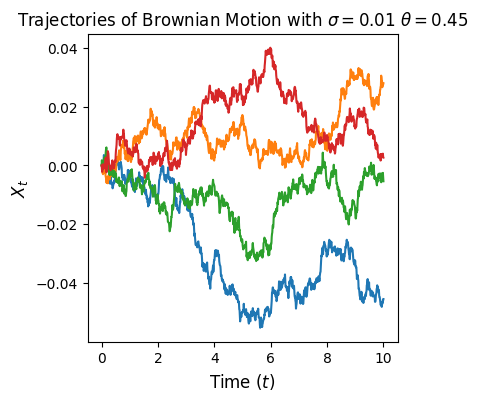

In [213]:
sigma = 0.01
geometric = Weiner(sigma=sigma)
simulator = EM(sde=geometric) 

x0 = torch.zeros(4, 1)
ts = torch.linspace(0.0, 10.0, 1000)

plt.figure(figsize=(4, 4))
ax = plt.gca()
ax.set_title(r'Trajectories of Brownian Motion with $\sigma=$' + str(sigma) + ' $\\theta=$' + str(theta), fontsize=12)
ax.set_xlabel(r'Time ($t$)', fontsize=12)
ax.set_ylabel(r'$X_t$', fontsize=12)
plot_trajectory(x0, simulator, ts, ax)
plt.show()

### Gaussian, GaussianMixture and Plotting

In [688]:
from torch.func import vmap, jacrev
import torch.distributions as D
from torch import nn
import numpy as np

In [571]:
class Density(ABC):
    @abstractmethod 
    def log_density(self, x):
        pass 
    
    def score(self, x):
        x.unsqueeze(1)
        score = vmap(jacrev(self.log_density))(x)
        return score.squeeze(1, 2, 3)

class Sampleable(ABC):
    @abstractmethod 
    def sample(self, n_samples: int):
        pass 


In [961]:
class Plotting:
    def __init__(self, sampler: Sampleable | Density, n_samples: Optional[int] = 10, ax: Optional[Axes] = None, **kwargs):
        self.sampler = sampler 
        self.n_samples = n_samples
        self.ax = ax if ax is not None else plt.gca()
        self.kwargs = kwargs 
    
    def scatter(self, x: torch.Tensor = None, y: torch.Tensor = None):
        if x is None or y is None:
            samples = self.sampler.sample(self.n_samples)
            x, y = samples[:, 0], samples[:, 1]
        self.ax.scatter(x, y, **self.kwargs)
    
    def plot_trajectory(self, x: torch.Tensor, y: torch.Tensor):
        self.ax.plot(x, y, **self.kwargs)


    def hist(self):
        samples = self.sampler.sample(self.n_samples)
        for idx in range(samples.shape[-1]):
            self.ax.hist(samples[:, idx], **self.kwargs)
    
    def hist2d(self):
        samples = self.sampler.sample(self.n_samples)
        x, y = samples[:, 0], samples[:, 1]
        self.ax.hist2d(x, y, **self.kwargs)
    
    def get_density(self, scale, bins):
        x = torch.linspace(-scale, scale, bins)
        y = torch.linspace(-scale, scale, bins)
        X, Y = torch.meshgrid(x, y) # make all possible pairs of x and y
        xy = torch.stack([X.flatten(), Y.flatten()], dim=-1)
        density = self.sampler.log_density(xy).view(bins, bins).T
        return density

    def imshow(self, scale: float, bins: int):
        density = self.get_density(scale, bins)        
        self.ax.imshow(
            density, 
            extent=[-scale, scale] * 2,
            origin='lower', 
            **self.kwargs
        )
    
    def contour(self, scale, bins):
        density = self.get_density(scale, bins)
        self.ax.contour(
            density, 
            extent=[-scale, scale] * 2,
            origin='lower',
            **self.kwargs
        )

In [717]:
class Gaussian(nn.Module, Sampleable, Density):
    def __init__(self, mean, cov):
        super().__init__()
        self.register_buffer('mean', mean)
        self.register_buffer('cov', cov)

    @property
    def distribution(self):
        return D.MultivariateNormal(self.mean, self.cov, validate_args=False)
    
    def log_density(self, x):
        return self.distribution.log_prob(x).view(-1, 1)

    def sample(self, n):
        return self.distribution.sample((n,))

class GaussianMixture(nn.Module, Sampleable, Density):
    def __init__(self, mean, cov, weight):
        super().__init__()
        self.register_buffer('mean', mean)
        self.register_buffer('cov', cov)
        self.register_buffer('weight', weight)
    
    @property
    def distribution(self):
        return D.MixtureSameFamily(
            mixture_distribution=D.Categorical(probs=self.weight, validate_args=False),
            component_distribution=D.MultivariateNormal(self.mean, self.cov, validate_args=False),
            validate_args=False 
        )

    def log_density(self, x: torch.Tensor):
        return self.distribution.log_prob(x).view(-1, 1)

    def sample(self, n_samples: int):
        return self.distribution.sample((n_samples,))
    
    @classmethod 
    def random2d(cls, n_dist: int, std: float, scale: float):
        mean = (torch.randn(n_dist, 2) - 0.5) * scale
        cov = torch.diag_embed(torch.ones(n_dist, 2)) * std ** 2 
        weight = torch.ones(n_dist)
        print(f'normal distribution with\n{mean=}\n{std=}')
        return cls(mean, cov, weight)
    
    @classmethod 
    def symmetric2d(cls, n_dist: int, std: float, scale: float):
        angles = torch.linspace(0, 2*np.pi, n_dist + 1)[:n_dist]
        mean = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1) * scale
        cov = torch.diag_embed(torch.ones(n_dist, 2)) * std ** 2 
        weight = torch.ones(n_dist)
        print(f'Distribution parameters\n{mean=}\n{std=}')
        return cls(mean, cov, weight)

In [731]:
std = 1.0
gaussians = {
    "gaussian": Gaussian(mean=torch.zeros(2), cov=torch.eye(2) * std),
    "random2d": GaussianMixture.random2d(n_dist=5, std=std, scale=10.0),
    "symmetric2d": GaussianMixture.symmetric2d(n_dist=5, std=std, scale=10.0)
}

normal distribution with
mean=tensor([[ 9.1744e+00, -7.8600e+00],
        [-2.0089e+01, -2.0179e+01],
        [ 3.8241e+00, -5.1015e+00],
        [-1.0053e+01, -2.1050e+01],
        [-7.1694e+00, -1.5309e-02]])
std=1.0
Distribution parameters
mean=tensor([[10.0000,  0.0000],
        [ 3.0902,  9.5106],
        [-8.0902,  5.8779],
        [-8.0902, -5.8779],
        [ 3.0902, -9.5106]])
std=1.0


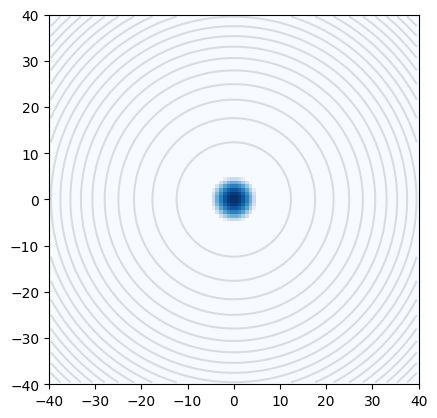

In [747]:
ax = plt.gca()
scale= 40
bins= 100
sampler = gaussians['gaussian']
Plotting(sampler, 100, ax, vmin=-15, cmap=plt.get_cmap('Blues')).imshow(scale=scale, bins=100)
Plotting(sampler,  100, ax, colors='grey', linestyles='solid', alpha=0.25, levels=20).contour(scale=scale, bins=100)

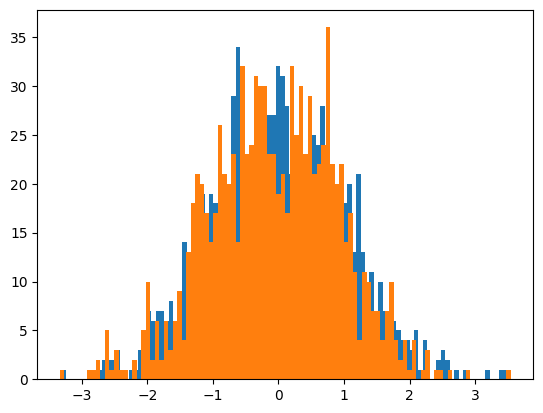

In [752]:
Plotting(sampler, 1000, bins=100).hist()

### Implementing Langevin Dynamic

$$dX_t = \frac{1}{2} \sigma^2\nabla \log p(X_t) dt + \sigma dW_t,$$

In [757]:
class langevin(SDE):
    def __init__(self, sigma: float, density: Density):
        self.density = density
        self.sigma = sigma

    def drift_comp(self, x, t):
        return 0.5 * self.sigma ** 2 * self.density.score(x)

    def diff_comp(self, x, t):
        return self.sigma * torch.ones_like(x)


In [784]:
sigma = 0.01
target = GaussianMixture.random2d(n_dist=5, std=1.0, scale=10.0)
langvinSDE = langevin(sigma=sigma, density=target)
sim = EM(sde=langvinSDE)

normal distribution with
mean=tensor([[ -8.0530, -20.9076],
        [  5.5720, -16.5490],
        [-13.4445, -12.2274],
        [ 11.4999, -26.8721],
        [-18.5270,   4.7800]])
std=1.0


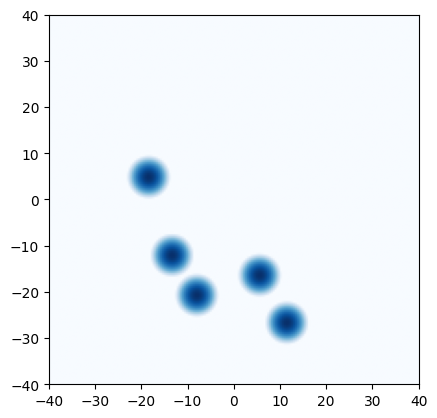

In [790]:
Plotting(target, 1000, vmin=-15, cmap=plt.get_cmap('Blues')).imshow(scale=40, bins=200)

In [954]:
x0 = torch.randn(100, 2) * 10
ts = torch.linspace(0.0, 10.0, 1000)

In [955]:
trajectory = sim.simulate_with_trajectory(x0, ts)

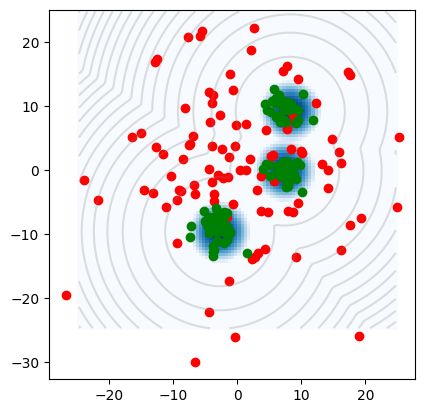

In [962]:
x0, y0 = trajectory[:, 0, 0], trajectory[:, 0, 1]
xt, yt = trajectory[:, -1, 0], trajectory[:, -1, 1]
ax = plt.gca() 
Plotting(target, ax=ax, color='r').scatter(x0, y0)
Plotting(target, ax=ax, color='g').scatter(xt, yt)
Plotting(target, ax=ax, vmin=-15, cmap=plt.get_cmap('Blues')).imshow(scale=25, bins=100)
Plotting(target, ax=ax, alpha=0.25, levels=20, linestyles='solid', colors='gray').contour(scale=25, bins=100)
# for idx in range(trajectory.shape[0]):
#     Plotting(target, ax=ax, color='gray').plot_trajectory(trajectory[idx, :, 0], trajectory[idx, :, 1])

### Simulating both ODE/SDE

In [34]:
from abc import ABC, abstractmethod
import torch
import numpy as np
from typing import Optional
import matplotlib.pyplot as plt 
from matplotlib.axes._axes import Axes

Drift component is the vector field $u_t(X_t)$  
Diffusion component is the random term $dW_t$

In [69]:
class ODE(ABC):
    @abstractmethod
    def drift_comp(self, x0: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """ d/dt Xt derivative/direction of the vector field """
        pass 

class SDE(ABC):
    @abstractmethod
    def drift_comp(self, x0: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """ d/dt Xt derivative/direction of the vector field """
        pass 

    def diff_comp(self, x0: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """ sigma for the weiner process """
        pass

In [25]:
class Simulator(ABC):
    @abstractmethod 
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor) -> torch.Tensor:
        """ perform gradient kind of update """
        pass 

    @torch.no_grad()
    def simulate(self, x0: torch.Tensor, ts: torch.Tensor) -> torch.Tensor:
        """" simulating the trajectory of x0 for all timesteps ts """
        for idx in range(1, len(ts)):
            h = ts[idx] - ts[idx - 1]
            t = ts[idx]
            x0 = self.step(x0, t, h)
        return x0

    @torch.no_grad() 
    def simulate_with_trajectory(self, x0: torch.Tensor, ts: torch.Tensor) -> torch.Tensor:
        trajectory = [x0.clone()]
        for idx in range(1, len(ts)):
            h = ts[idx] - ts[idx - 1]
            t = ts[idx]
            x0 = self.step(x0, t, h)
            trajectory.append(x0.clone())
        return torch.stack(trajectory, dim=1)

In [50]:
class Euler(Simulator):
    def __init__(self, ode: ODE):
        self.ode = ode 
    
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor) -> torch.Tensor:
        return xt + self.ode.drift_comp(xt, t) * h
    
class EulerMaruyama(Simulator):
    def __init__(self, sde: SDE):
        self.sde = sde 
    
    def step(self, x0, t, h):
        return x0 + self.sde.drift_comp(x0, t) * h + self.sde.diff_comp(x0, t) * torch.sqrt(h) * torch.randn_like(x0)

Simulating the simplest vector field $dX_t = -\theta X_t dt$

In [45]:
class VF(ODE):
    def __init__(self, theta: float):
        self.theta = theta 

    def drift_comp(self, xt, t):
        return - self.theta * xt

class Weiner(SDE):
    def __init__(self, theta, sigma):
        self.theta = theta 
        self.sigma = sigma 

    def drift_comp(self, x0, t):
        return torch.zeros_like(x0)
    
    def diff_comp(self, x0, t):
        return self.sigma * torch.ones_like(x0)


In [46]:
def plot_trajectories_1d(x0: torch.Tensor, simulator: Simulator, timesteps: torch.Tensor, ax: Optional[Axes] = None):
        """
        Graphs the trajectories of a one-dimensional SDE with given initial values (x0) and simulation timesteps (timesteps).
        Args:
            - x0: state at time t, shape (num_trajectories, 1)
            - simulator: Simulator object used to simulate
            - t: timesteps to simulate along, shape (num_timesteps,)
            - ax: pyplot Axes object to plot on
        """
        if ax is None:
            ax = plt.gca()
        trajectories = simulator.simulate_with_trajectory(x0, timesteps) # (num_trajectories, num_timesteps, ...)
        for trajectory_idx in range(trajectories.shape[0]):
            trajectory = trajectories[trajectory_idx, :, 0] # (num_timesteps,)
            ax.plot(ts.cpu(), trajectory.cpu())

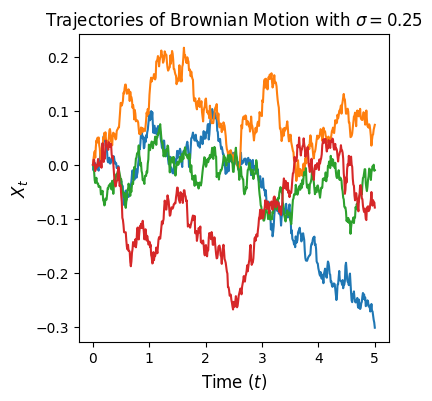

In [67]:
theta = 0.25 
vf = Weiner(theta=theta, sigma=0.1)
simulator = EulerMaruyama(sde=vf)
x0 = torch.zeros(4,1) # Initial values - let's start at zero
ts = torch.linspace(0.0,5.0,500) # simulation timesteps

plt.figure(figsize=(4, 4))
ax = plt.gca()
ax.set_title(r'Trajectories of Brownian Motion with $\sigma=$' + str(theta), fontsize=12)
ax.set_xlabel(r'Time ($t$)', fontsize=12)
ax.set_ylabel(r'$X_t$', fontsize=12)
plot_trajectories_1d(x0, simulator, ts, ax)
plt.show()